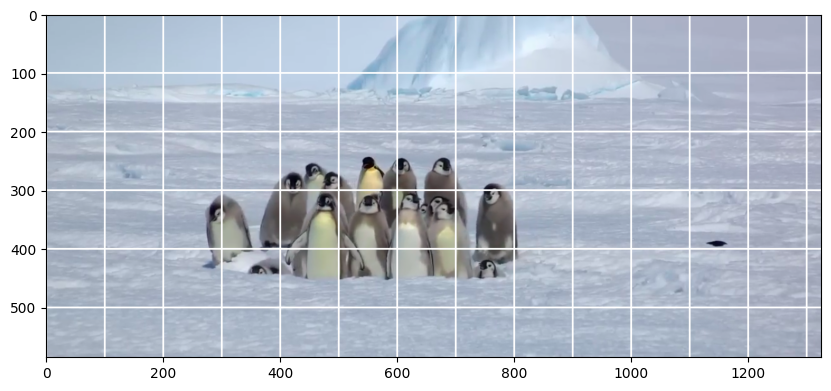

In [ ]:
import cv2
import matplotlib.pyplot as plt

def make_pixel_grid_with_lines(image_path, output_path):
    # Load the image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Add grid lines and pixel labels
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.7
    color = (255, 255, 255)  # White color in RGB
    thickness = 2

    step = 100  # Distance between lines

    for x in range(0, image.shape[1], step):  # Vertical lines
        cv2.line(image, (x, 0), (x, image.shape[0] - 1), color, thickness)
        # cv2.putText(image, f'{x}', (x + 5, 15), font, font_scale, color, thickness)

    for y in range(0, image.shape[0], step):  # Horizontal lines
        cv2.line(image, (0, y), (image.shape[1] - 1, y), color, thickness)
        # cv2.putText(image, f'{y}', (5, y + 15), font, font_scale, color, thickness)

    # Display the image with matplotlib and save with tight layout
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    plt.axis('on')  # Show axes with pixel values
    plt.grid(False)  # Disable Matplotlib's default grid

    # Save the image without extra white space
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0)
    plt.show()

make_pixel_grid_with_lines(image_path = '/content/img_3.png', output_path="/content/new_img.png")

In [ ]:
!pip install anthropic

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 9.2 MB/s eta 0:00:00


In [ ]:
from anthropic import Anthropic
import json

In [ ]:
import anthropic
import json
import base64
import mimetypes

def analyze_image_coordinates(api_key, image_path, objects_to_find):
    client = Anthropic(api_key=api_key)

    mime_type = 'image/png'  # Default to PNG if can't detect

    # Read and encode image
    with open(image_path, "rb") as f:
        image_bytes = f.read()
        image_base64 = base64.b64encode(image_bytes).decode('utf-8')

    # prompt = f"""Please analyze this image and provide the center coordinates (x, y) for the following objects: {', '.join(objects_to_find)}.
    # Return only the coordinates in JSON format like: {{"object_name": [x, y]}}
    # Please use pixel values visible in the image."""

    prompt = f"I have an image containing specific objects. The image is divided into a grid with labeled coordinates for both x and y axes. Please identify the an point (x, y) coordinates of the specified objects in the image, make sure that the point lies in that object not at extreme end of object. For this image, the objects to locate are [{', '.join(objects_to_find)}]. Provide the coordinates for each object based on the grid."

    try:
        message = client.messages.create(
            model="claude-3-haiku-20240307",
            max_tokens=1000,
            messages=[{
                "role": "user",
                "content": [
                    {
                        "type": "text",
                        "text": prompt
                    },
                    {
                        "type": "image",
                        "source": {
                            "type": "base64",
                            "media_type": mime_type,
                            "data": image_base64
                        }
                    }
                ]
            }]
        )
        return json.loads(message.content[0].text)
    except json.JSONDecodeError:
        print("Raw response:", message.content[0].text)
        return "Error: Could not parse coordinates from response"
    except Exception as e:
        print(f"Error: {str(e)}")
        return None

In [ ]:
API_KEY = ""
ANNOTED_FRAME_PATH = "/content/new_img.png"
coordinates = analyze_image_coordinates(api_key=API_KEY, image_path=ANNOTED_FRAME_PATH, objects_to_find=['peguin'])
print(coordinates)

Raw response: The image shows a group of penguins. Based on the grid coordinates provided, the coordinates for the penguins are:

(265, 375)
(270, 390)
(275, 375)
(280, 390)
(285, 375)
(290, 390)
(295, 375)
Error: Could not parse coordinates from response


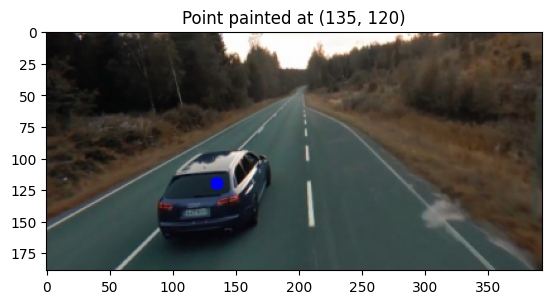

In [ ]:
import cv2
import matplotlib.pyplot as plt

def paint_point_on_image(image_path, x, y, output_path=None, point_color=(255, 0, 0), point_radius=5):
    """
    Paint a point at (x, y) on the image and display it.

    Args:
        image_path (str): Path to the input image.
        x (int): X-coordinate of the point.
        y (int): Y-coordinate of the point.
        output_path (str, optional): Path to save the output image (optional).
        point_color (tuple): Color of the point in BGR format (default: red).
        point_radius (int): Radius of the point to be drawn (default: 5).
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return

    # Paint the point on the image
    cv2.circle(image, (x, y), radius=point_radius, color=point_color, thickness=-1)

    # Convert to RGB for displaying in matplotlib
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image with matplotlib
    plt.imshow(image_rgb)
    plt.axis('on')
    plt.title(f"Point painted at ({x}, {y})")
    plt.show()

    # Save the image if an output path is provided
    if output_path:
        cv2.imwrite(output_path, image)

# Example usage
image_path = "/content/img_1.png"
x = 135  # X-coordinate
y = 120  # Y-coordinate
output_path = "/content/image_with_point.png"  # Optional: Path to save the output image

paint_point_on_image(image_path, x, y, output_path)


In [ ]:
import re
import numpy as np

def extract_coordinates(response, num_objects):
    """
    Extracts coordinates from the response text, ensuring the number of coordinates
    matches the specified number of objects. If more coordinates are provided for an
    object, it selects the central coordinate.

    Args:
        response (str): Raw response text containing coordinates.
        num_objects (int): Expected number of objects and corresponding coordinates.

    Returns:
        list: A list of (x, y) tuples representing the coordinates for the objects.
    """
    try:
        # Extract all coordinates from the response using regex
        coordinates = re.findall(r"\((\d+),\s*(\d+)\)", response)
        coordinates = [(int(x), int(y)) for x, y in coordinates]

        # If the number of extracted coordinates matches the expected number, return them
        if len(coordinates) == num_objects:
            return coordinates

        # If more coordinates are provided, group and select the central one for each object
        elif len(coordinates) > num_objects:
            # Calculate the central coordinate
            center_x = np.mean([x for x, y in coordinates])
            center_y = np.mean([y for x, y in coordinates])

            # Sort by distance to the central point
            coordinates_sorted = sorted(
                coordinates,
                key=lambda coord: np.sqrt((coord[0] - center_x) ** 2 + (coord[1] - center_y) ** 2)
            )

            # Return the first 'num_objects' coordinates
            return coordinates_sorted[:num_objects]

        else:
            raise ValueError("Not enough coordinates extracted for the specified number of objects.")

    except Exception as e:
        print(f"Error: Could not parse coordinates from response\n{e}")
        return []

# Example usage
response_1 = """
Raw response: Based on the image provided, the coordinates for the specified objects are:
Person: (270, 120)
Watercraft: (650, 200)
"""
response_2 = """
Raw response: The image shows a group of penguins. Based on the grid coordinates provided, the coordinates for the penguins are:
(265, 375)
(270, 390)
(275, 375)
(280, 390)
(285, 375)
(290, 390)
(295, 375)
"""

# Testing with response 1 (2 objects expected)
coordinates_1 = extract_coordinates(response_1, 2)
print(f"Extracted coordinates (Response 1): {coordinates_1}")

# Testing with response 2 (1 object expected)
coordinates_2 = extract_coordinates(response_2, 1)
print(f"Extracted coordinates (Response 2): {coordinates_2}")


Extracted coordinates (Response 1): [(270, 120), (650, 200)]
Extracted coordinates (Response 2): [(275, 375)]
